# RAG

In [1]:
## setup
!pip install anthropic
!pip install voyageai
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install -U scikit-learn

In [1]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()
os.environ['VOYAGE_API_KEY'] = ('VOYAGE_API_KEY')
openai.api_key = os.getenv("OPENAI_API_KEY")


# Initialize a Vector DB Class

In [ ]:
"""
Como o produto escalar não é escalavel, vamos testar o Approximate Nearest Neighbor (ANN) que utiliza 
estruturas de dados específicas e heurísticas para dividir o espaço vetorial e acelerar a busca.
"""

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 20.2 MB/s eta 0:00:00a 0:00:01


In [11]:
import os
import pickle
import json
import numpy as np
import openai

import faiss 

class VectorDB:
    def __init__(self, name, api_key=None):
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/vector_db.pkl"
        self.index = None  # Índice FAISS

    def load_data(self, data):
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [f"Heading: {item['chunk_heading']}\n\n Chunk Text: {item['text']}" for item in data]
        self._embed_and_store(texts, data)
        self._build_faiss_index()  # Constrói o índice ANN
        self.save_db()
        print("Vector database loaded, indexed, and saved.")

    def _embed_and_store(self, texts, data):
        batch_size = 128
        result = []

        for i in range(0, len(texts), batch_size):
            response = openai.Embedding.create(
                input=texts[i: i + batch_size],
                model="text-embedding-ada-002"
            )
            embeddings = [res['embedding'] for res in response['data']]
            result.extend(embeddings)

        self.embeddings = np.array(result, dtype=np.float32)  # FAISS exige float32
        self.metadata = data

    def _build_faiss_index(self):
        if self.embeddings is None or len(self.embeddings) == 0:
            raise ValueError("No embeddings available to build the index.")

        dimension = self.embeddings.shape[1]  # Dimensão dos vetores
        self.index = faiss.IndexFlatL2(dimension)  # Índice para busca por similaridade (L2)
        self.index.add(self.embeddings)  # Adiciona os embeddings ao índice
        print(f"FAISS index built with {len(self.embeddings)} embeddings.")

    def search(self, query, k=5, similarity_threshold=0.35):
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            response = openai.Embedding.create(
                input=[query],
                model="text-embedding-ada-002"
            )
            query_embedding = np.array(response['data'][0]['embedding'], dtype=np.float32)
            self.query_cache[query] = query_embedding

        if self.index is None:
            raise ValueError("FAISS index not built. Load data first.")

        # Busca ANN com FAISS
        distances, indices = self.index.search(np.array([query_embedding]), k)
        
        top_examples = []
        for i, idx in enumerate(indices[0]):
            if idx == -1:  # Verifica se o índice é válido
                continue

            similarity = 1 / (1 + distances[0][i])  # Converte distância para similaridade (opcional)
            if similarity >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarity,
                }
                top_examples.append(example)

        return top_examples

    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        self.embeddings = np.array(data["embeddings"], dtype=np.float32)
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])
        self._build_faiss_index()  # Reconstrói o índice FAISS ao carregar os dados

# Basic RAG

In [12]:
from hugchat import hugchat
from hugchat.login import Login
import time
import json

# Configurações de login
EMAIL = "hdsdosol@gmail.com"
PASSWD = "Lisa2210@"
cookie_path_dir = "./cookies/"  # O diretório onde os cookies serão salvos

# Login no HuggingFace
sign = Login(EMAIL, PASSWD)
cookies = sign.login(cookie_dir_path=cookie_path_dir, save_cookies=True)

# Cria o ChatBot com cookies obtidos
chatbot = hugchat.ChatBot(cookies=cookies.get_dict())

# Função para chamar o modelo via HuggingChat
def call_huggingchat(prompt, model_name, retries=3, delay=20):
    models = chatbot.get_available_llm_models()
    model_index = next((i for i, m in enumerate(models) if m.id == model_name), None)

    if model_index is not None:
        chatbot.switch_llm(model_index)
        print(f"Modelo '{model_name}' selecionado com sucesso!")
    else:
        raise ValueError(f"Modelo '{model_name}' não encontrado entre os disponíveis.")

    for attempt in range(retries):
        try:
            chatbot.new_conversation(switch_to=True)
            response = chatbot.chat(prompt)
            return response
        except Exception as e:
            print(f"Erro na tentativa {attempt + 1}: {e}")
            if "You are sending too many messages" in str(e):
                time.sleep(delay)
            else:
                break

    return None

# Carregar o documento do seu caminho específico
with open('/home/lisamenezes/RAG-benchmark/data/fundamentos-all.json', 'r') as f:
    fundamentos_data = json.load(f)

def validate_data(data):
    for i, item in enumerate(data):
        if 'chunk_heading' not in item or not item['chunk_heading']:
            print(f"[DEBUG] Missing or empty 'chunk_heading' in item {i}: {item}")
        if 'text' not in item or not item['text']:
            print(f"[DEBUG] Missing or empty 'text' in item {i}: {item}")
        if 'context' not in item:
            print(f"[DEBUG] Missing 'context' field in item {i}, adding default value.")
            item['context'] = "No context available."
    return data

# Inicializar o VectorDB com seus dados
db = VectorDB("fundamentos")
db.load_data(fundamentos_data)

def retrieve_base(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n{chunk['text']}\n"
        # print(context)
        # print("Resultados da busca:", results)
    return results, context

FAISS index built with 18499 embeddings.
Vector database loaded, indexed, and saved.


In [13]:
def answer_query_base(query, db):
    documents, context = retrieve_base(query, db)
    prompt = f"""
    Você é um assistente juridico que responde a seguinte pergunta: 
    <pergunta>
    {query}
    </pergunta>
    Você tem acesso aos seguintes documentos, que devem fornecer contexto à medida que responde à consulta:
    <contexto>
    {context}
    </contexto>
    Por favor, permaneça fiel ao contexto subjacente e só se desvie dele se tiver 100% de certeza de que já sabe a resposta. 
    Responda à pergunta agora e evite fornecer preâmbulos como 'Aqui está a resposta', etc.
    """
    
    response = call_huggingchat(prompt, model_name="meta-llama/Meta-Llama-3.1-70B-Instruct")
    return response

In [15]:
import time
# Exemplo de uso para realizar uma consulta e gerar uma resposta
start = time.time()
query = "posse provisória"
results, context = retrieve_base(query, db)
end = time.time()

print("Contexto Recuperado:")
print(context)

print("Tempo de execução")
print(end-start)
# Gerar o texto usando o LLM
response = answer_query_base(query, db)

print("\nTexto Gerado pelo LLM:")
print(response)


Contexto Recuperado:

Art. 30 - § 1oAquele que tiver direito à posse provisória, mas não puder
prestar a garantia exigida neste artigo, será excluído, mantendo-se os bens que lhe
deviam caber sob a administração do curador, ou de outro herdeiro designado pelo juiz, e
que preste essa garantia.

Art. 30 - § 1oAquele que tiver direito à posse provisória, mas não puder
prestar a garantia exigida neste artigo, será excluído, mantendo-se os bens que lhe
deviam caber sob a administração do curador, ou de outro herdeiro designado pelo juiz, e
que preste essa garantia.

Art. 1.211. Quando mais de uma pessoa se disser possuidora, manter-se-á
provisoriamente a que tiver a coisa, se não estiver manifesto que a obteve de alguma das
outras por modo vicioso.

Tempo de execução
0.027214765548706055
Modelo 'meta-llama/Meta-Llama-3.1-70B-Instruct' selecionado com sucesso!

Texto Gerado pelo LLM:
A posse provisória é um instituto jurídico que permite a alguém exercer a posse de um bem ou direito, mesmo q

# Validação

In [16]:
from tqdm import tqdm

def evaluate_rag_output(context, chunk_heading, text, model="gpt-3.5-turbo"):
    """
    Avalia se a saída do RAG está alinhada com o termo de busca e o texto de referência.

    Args:
        context (str): O contexto recuperado pelo RAG.
        chunk_heading (str): O termo de busca.
        text (str): O texto de referência correto do chunk.
        model (str): O modelo GPT a ser usado (padrão: gpt-4).

    Returns:
        str: Resposta do GPT com o julgamento.
    """
    prompt = f"""
    Você é um modelo treinado para avaliar respostas de sistemas baseados em Recuperação-Aumentada por Geração (RAG).
    Sua tarefa é julgar se o "contexto" recuperado pelo RAG está alinhado com o "termo de busca" (chunk_heading) e com o "texto de referência correto" (text).

    Aqui estão as informações fornecidas:
    - Contexto recuperado no RAG (3 contextos):
    {context}

    - Termo de busca:
    {chunk_heading}

    - Texto de referência correto:
    {text}

    Julgue se ao menos 1 dos 3 contextos é igual ao texto de referência, isso significará que o contexto está adequado ao termo de busca.
    Responda com "adequado" ou "inadequado".
    Não adicione nenhum comentário extra.
    # Formato da saída:
    Ex.:'adequado'
    Ex.:'inadequado'
    """
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        return response["choices"][0]["message"]["content"]
    except Exception as e:
        return f"Erro ao avaliar: {str(e)}"


# Interação com o JSON de teste
def evaluate_test_data(test_data, db):
    """
    Itera sobre um JSON de teste e avalia cada entrada usando o GPT como julgador.

    Args:
        test_data (list): Lista de entradas do JSON de teste.
        db (VectorDB): Instância do banco de vetores carregado.

    Returns:
        list: Resultados das avaliações.
    """
    results = []
    for item in tqdm(test_data, desc="LLM as a judge: ", unit="entrada"):
        chunk_heading = item["chunk_heading"]
        text = item["text"]
        _, context = retrieve_base(chunk_heading, db)

        evaluation = evaluate_rag_output(context, chunk_heading, text)
        results.append({
            "chunk_heading": chunk_heading,
            "context": context,
            "text": text,
            "evaluation": evaluation
        })

    return results


# Carregar dados de teste e avaliar
with open('/home/lisamenezes/RAG-benchmark/data/fundamentos-test.json', 'r') as f:
    test_data = json.load(f)

evaluation_results = evaluate_test_data(test_data, db)

# Salvar os resultados para análise posterior
with open('/home/lisamenezes/RAG-benchmark/results/3_small_ann.json', 'w') as f:
    json.dump(evaluation_results, f, ensure_ascii=False, indent=4)


LLM as a judge:   0%|          | 0/100 [00:00<?, ?entrada/s]

LLM as a judge: 100%|██████████| 100/100 [01:39<00:00,  1.00entrada/s]


Porcentagem de avaliações adequadas: 85.00%


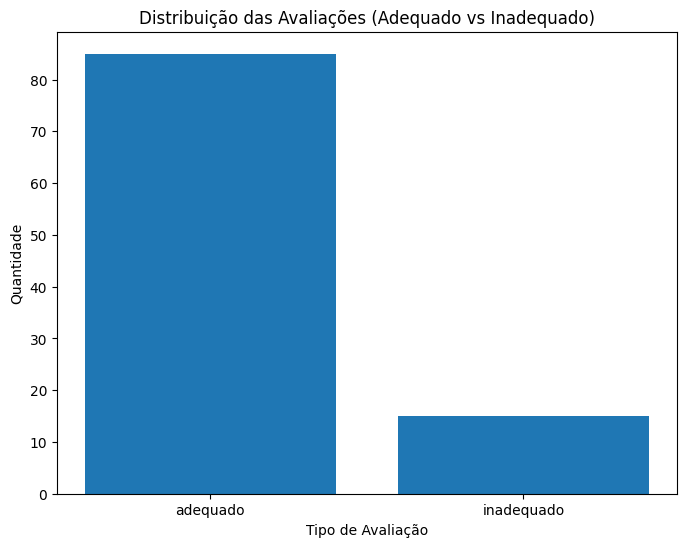

In [18]:
import json
import matplotlib.pyplot as plt

# Carregar os resultados de avaliação
with open('/home/lisamenezes/RAG-benchmark/results/3_small_ann.json', 'r') as f:
    evaluation_results = json.load(f)

# Contar as avaliações adequadas e inadequadas
evaluation_counts = {"adequado": 0, "inadequado": 0}
for result in evaluation_results:
    evaluation = result["evaluation"].lower()  # Garantir consistência de casos
    if evaluation in evaluation_counts:
        evaluation_counts[evaluation] += 1

# Calcular a porcentagem de adequados
total = sum(evaluation_counts.values())
percentage_adequados = (evaluation_counts["adequado"] / total) * 100 if total > 0 else 0

# Criar o gráfico
labels = list(evaluation_counts.keys())
sizes = list(evaluation_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes)
plt.title("Distribuição das Avaliações (Adequado vs Inadequado)")
plt.xlabel("Tipo de Avaliação")
plt.ylabel("Quantidade")
plt.xticks(labels)

# Mostrar a porcentagem de adequados no console
print(f"Porcentagem de avaliações adequadas: {percentage_adequados:.2f}%")

plt.show()